In [1]:
import random
from pathlib import Path

import torch
import torchvision.models as models
from torchvision import transforms
from torchinfo import summary

from load_data_functions import create_cv_datasets, create_dataloaders
from engine import load_adapted_emonet, get_loss_optimizer, create_writer, train, pretty_json, plot_loss_curves, pred_and_plot_n_images, calculate_cv_performance

In [2]:
# get current hyperparameter setup
batch_size = 64
loss_fn_str = "MSE"
learning_rate = 0.001
optimizer_str = "Adam"
num_epochs = 10
train_percentage = 1.0

In [3]:
# other variables relevant for training
split_path = Path("data/train_test_split")
fold_list = [split_path / f"fold_{i}" for i in range(1, 6)]
img_size = 256
model_name = "adapted_emonet"

In [4]:
# setup device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
# create a writer to track training results
writer = create_writer(f"model_selection_cv", model_name)

[INFO] Created SummaryWriter, saving to: runs\model_selection_cv\adapted_emonet\2024-05-26_13-28-53...


In [6]:
# track hyperparameters and other important information
info = {
        "model_name": model_name,
        "batch_size": batch_size,
        "loss_fn_str": loss_fn_str,
        "learning_rate": learning_rate,
        "split_path": str(split_path),
        "fold_list": [str(fold) for fold in fold_list],
        "img_size": img_size,
        "num_epochs": num_epochs,
        "optimizer_str": optimizer_str,
        "percentage": train_percentage
    }

writer.add_text("Miscellaneous", pretty_json(info))

In [7]:
# define the transforms (standard transforms are performed, as these are not specified in Toisoul et al., 2021)
data_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [8]:
# perform cross_validation
datasets = create_cv_datasets(fold_list, data_transforms, select_one=False, train_percentage=train_percentage)
cv_results = {}
for fold in datasets.keys():
    train_data = datasets[fold]["train"]
    validation_data = datasets[fold]["validation"]
    print("\n----------------------------------------------------------------------------------------")
    print(f"Size of the training set: {len(train_data)}")
    print(f"Size of the validation set: {len(validation_data)}")
    train_loader, val_loader = create_dataloaders(train_data, validation_data, device, batch_size)

    # initialize model and optimizer
    model = load_adapted_emonet(device)
    loss_fn, optimizer = get_loss_optimizer(loss_fn_str, optimizer_str, model, learning_rate)

    print(f"Training results for {fold}:")
    cv_results[fold] = train(num_epochs=num_epochs,
                             model=model,
                             train_loader=train_loader,
                             val_loader=val_loader,
                             loss_fn=loss_fn,
                             optimizer=optimizer,
                             device=device,
                             writer=writer,
                             early_stopping=False)


----------------------------------------------------------------------------------------
Size of the training set: 19803
Size of the validation set: 4915
[INFO] Created a new baseline EmoNet model.
Training results for fold_1:


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0386 | train_ccc: 0.7552 | train_pcc: 0.7767 | val_loss: 0.1541 | val_ccc: 0.1329 | val_pcc: 0.2933
Epoch: 2 | train_loss: 0.0178 | train_ccc: 0.8687 | train_pcc: 0.8841 | val_loss: 0.1918 | val_ccc: 0.1184 | val_pcc: 0.3399
Epoch: 3 | train_loss: 0.0155 | train_ccc: 0.8889 | train_pcc: 0.9055 | val_loss: 0.2559 | val_ccc: 0.1023 | val_pcc: 0.3548
Epoch: 4 | train_loss: 0.0129 | train_ccc: 0.9081 | train_pcc: 0.9207 | val_loss: 0.1113 | val_ccc: 0.1960 | val_pcc: 0.3117
Epoch: 5 | train_loss: 0.0119 | train_ccc: 0.9151 | train_pcc: 0.9280 | val_loss: 0.0745 | val_ccc: 0.2292 | val_pcc: 0.3618
Epoch: 6 | train_loss: 0.0111 | train_ccc: 0.9221 | train_pcc: 0.9348 | val_loss: 0.1820 | val_ccc: 0.1252 | val_pcc: 0.3703
Epoch: 7 | train_loss: 0.0102 | train_ccc: 0.9288 | train_pcc: 0.9412 | val_loss: 0.1507 | val_ccc: 0.1387 | val_pcc: 0.3598
Epoch: 8 | train_loss: 0.0101 | train_ccc: 0.9295 | train_pcc: 0.9420 | val_loss: 0.0892 | val_ccc: 0.1905 | val_pcc: 0.2680


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0408 | train_ccc: 0.7403 | train_pcc: 0.7636 | val_loss: 0.3436 | val_ccc: 0.0614 | val_pcc: 0.2986
Epoch: 2 | train_loss: 0.0189 | train_ccc: 0.8594 | train_pcc: 0.8754 | val_loss: 0.0625 | val_ccc: 0.1677 | val_pcc: 0.2547
Epoch: 3 | train_loss: 0.0153 | train_ccc: 0.8892 | train_pcc: 0.9036 | val_loss: 0.0826 | val_ccc: 0.1874 | val_pcc: 0.3157
Epoch: 4 | train_loss: 0.0135 | train_ccc: 0.9022 | train_pcc: 0.9158 | val_loss: 0.0583 | val_ccc: 0.1694 | val_pcc: 0.2789
Epoch: 5 | train_loss: 0.0123 | train_ccc: 0.9121 | train_pcc: 0.9258 | val_loss: 0.1140 | val_ccc: 0.1248 | val_pcc: 0.2548
Epoch: 6 | train_loss: 0.0112 | train_ccc: 0.9205 | train_pcc: 0.9314 | val_loss: 0.0875 | val_ccc: 0.1587 | val_pcc: 0.2555
Epoch: 7 | train_loss: 0.0105 | train_ccc: 0.9258 | train_pcc: 0.9378 | val_loss: 0.1603 | val_ccc: 0.1286 | val_pcc: 0.3171
Epoch: 8 | train_loss: 0.0103 | train_ccc: 0.9273 | train_pcc: 0.9401 | val_loss: 0.0584 | val_ccc: 0.1637 | val_pcc: 0.2408


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0400 | train_ccc: 0.7531 | train_pcc: 0.7763 | val_loss: 0.2118 | val_ccc: 0.0981 | val_pcc: 0.2320
Epoch: 2 | train_loss: 0.0180 | train_ccc: 0.8728 | train_pcc: 0.8883 | val_loss: 0.0898 | val_ccc: 0.1760 | val_pcc: 0.3314
Epoch: 3 | train_loss: 0.0151 | train_ccc: 0.8946 | train_pcc: 0.9087 | val_loss: 0.1038 | val_ccc: 0.1132 | val_pcc: 0.2570
Epoch: 4 | train_loss: 0.0134 | train_ccc: 0.9074 | train_pcc: 0.9211 | val_loss: 0.1796 | val_ccc: 0.0617 | val_pcc: 0.1430
Epoch: 5 | train_loss: 0.0117 | train_ccc: 0.9197 | train_pcc: 0.9311 | val_loss: 0.1806 | val_ccc: 0.0932 | val_pcc: 0.2573
Epoch: 6 | train_loss: 0.0110 | train_ccc: 0.9246 | train_pcc: 0.9355 | val_loss: 0.0617 | val_ccc: 0.1524 | val_pcc: 0.2417
Epoch: 7 | train_loss: 0.0109 | train_ccc: 0.9261 | train_pcc: 0.9385 | val_loss: 0.1929 | val_ccc: 0.0854 | val_pcc: 0.2334
Epoch: 8 | train_loss: 0.0099 | train_ccc: 0.9329 | train_pcc: 0.9437 | val_loss: 0.0771 | val_ccc: 0.1588 | val_pcc: 0.2985


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0383 | train_ccc: 0.7670 | train_pcc: 0.7890 | val_loss: 0.3045 | val_ccc: 0.0552 | val_pcc: 0.1903
Epoch: 2 | train_loss: 0.0178 | train_ccc: 0.8724 | train_pcc: 0.8882 | val_loss: 0.0923 | val_ccc: 0.1705 | val_pcc: 0.2857
Epoch: 3 | train_loss: 0.0153 | train_ccc: 0.8933 | train_pcc: 0.9093 | val_loss: 0.0665 | val_ccc: 0.2200 | val_pcc: 0.3142
Epoch: 4 | train_loss: 0.0130 | train_ccc: 0.9101 | train_pcc: 0.9241 | val_loss: 0.1428 | val_ccc: 0.0982 | val_pcc: 0.2187
Epoch: 5 | train_loss: 0.0120 | train_ccc: 0.9180 | train_pcc: 0.9316 | val_loss: 0.0549 | val_ccc: 0.2486 | val_pcc: 0.3747
Epoch: 6 | train_loss: 0.0112 | train_ccc: 0.9233 | train_pcc: 0.9351 | val_loss: 0.0892 | val_ccc: 0.1821 | val_pcc: 0.3067
Epoch: 7 | train_loss: 0.0106 | train_ccc: 0.9284 | train_pcc: 0.9403 | val_loss: 0.0915 | val_ccc: 0.1307 | val_pcc: 0.3063
Epoch: 8 | train_loss: 0.0097 | train_ccc: 0.9339 | train_pcc: 0.9447 | val_loss: 0.2207 | val_ccc: 0.0612 | val_pcc: 0.2810


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0392 | train_ccc: 0.7549 | train_pcc: 0.7760 | val_loss: 0.1620 | val_ccc: 0.1742 | val_pcc: 0.3239
Epoch: 2 | train_loss: 0.0188 | train_ccc: 0.8629 | train_pcc: 0.8791 | val_loss: 0.0799 | val_ccc: 0.1558 | val_pcc: 0.2705
Epoch: 3 | train_loss: 0.0153 | train_ccc: 0.8895 | train_pcc: 0.9038 | val_loss: 0.2493 | val_ccc: 0.0342 | val_pcc: 0.1336
Epoch: 4 | train_loss: 0.0133 | train_ccc: 0.9050 | train_pcc: 0.9172 | val_loss: 0.0794 | val_ccc: 0.1562 | val_pcc: 0.2157
Epoch: 5 | train_loss: 0.0123 | train_ccc: 0.9135 | train_pcc: 0.9281 | val_loss: 0.0696 | val_ccc: 0.1686 | val_pcc: 0.2741
Epoch: 6 | train_loss: 0.0114 | train_ccc: 0.9206 | train_pcc: 0.9338 | val_loss: 0.0723 | val_ccc: 0.1586 | val_pcc: 0.2629
Epoch: 7 | train_loss: 0.0106 | train_ccc: 0.9255 | train_pcc: 0.9375 | val_loss: 0.0752 | val_ccc: 0.2172 | val_pcc: 0.3249
Epoch: 8 | train_loss: 0.0099 | train_ccc: 0.9306 | train_pcc: 0.9421 | val_loss: 0.1332 | val_ccc: 0.1621 | val_pcc: 0.3116


In [9]:
# calculate average performance across folds 
cv_performance = calculate_cv_performance(cv_results, num_epochs, writer)

{'mean_ccc': [0.10435836246336216, 0.1576760560081269, 0.131408068784071, 0.1363025848148965, 0.17289629764062364, 0.15541196937977836, 0.14010797613674986, 0.14725770813684316, 0.09629689286283259, 0.11432585607493437], 'mean_pcc': [0.2676325717233182, 0.2964442736841765, 0.2750759858522874, 0.2335732939615598, 0.3045271766597279, 0.2874149853458184, 0.3083120813335928, 0.27995669921946115, 0.2738658929952806, 0.31067092832045257]}


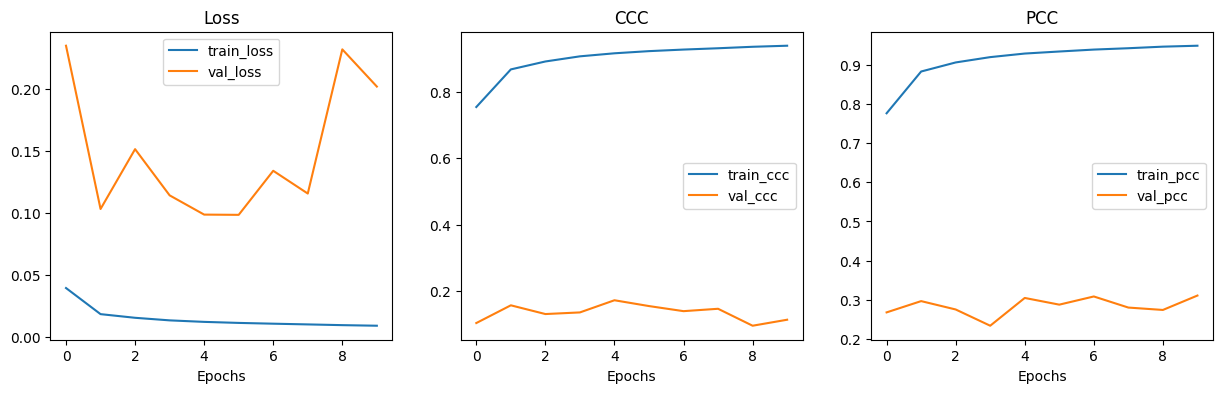

In [10]:
# plot loss curves
plot_loss_curves(cv_performance)